In [1]:
import torch
from transformers import AutoModel,AutoConfig,AutoTokenizer,AutoModelForSequenceClassification,Trainer,TrainingArguments,DataCollatorWithPadding
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datasets import load_dataset, Dataset, DatasetDict
import evaluate
import re

/usr/local/miniconda3/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%%time
# 加载数据
excel_file = './10w.xlsx'
data_frame = pd.read_excel(excel_file)

CPU times: user 18.3 s, sys: 81.3 ms, total: 18.4 s
Wall time: 18.4 s


In [3]:
# # 随机抽样（预实验使用）
# data_frame = data_frame.sample(n=10000)
# data_frame

In [4]:
# 停用词预处理
stop_words = ['您好','你好',':很高兴为您服务','请问有什么可以帮您','client','user',' ']
sep_words = ['。', '!', '?', ',']
def ProcessStopWords(text):
    for word in stop_words:
        text = text.replace(word,'')
    text = text.replace(':','[SEP]').replace('[SEP]','',1) # 删除第一个[SEP]
    for word in sep_words:
        text = text.replace(word, '[SEP]')
    return text

data_frame['转写文本'] = data_frame['转写文本'].map(ProcessStopWords)

In [5]:
data_frame['转写文本'].iloc[0]

'哎我想问一下[SEP]我这个一三九的号码那个扣费方式是怎么样的[SEP]扣费方式的话它是每个月呢就是每个月的一个基本月租[SEP]49.7元[SEP]然后的话加上您的副卡十块钱[SEP]然后的话每个月就是五十九块七毛钱这样子的一个月[SEP]月租每个月1[SEP]一号再这样子扣月[SEP]不是我是问是从那个[SEP]银行里面因为是这样子我是从联[SEP]呃移动刚刚转过来的我以前绑定的是[SEP]建行的那个什么银行卡[SEP]是先付费后扣[SEP]给我扣款[SEP]我想问一下就是这么转过来了你那里有[SEP]我的那个什么[SEP]银行扣款方式吗还是[SEP]没有的[SEP]那我这个话费怎么交呢[SEP]话费的话您直接在app上面进行一个充值就可以了[SEP]是先付费还是后付费的[SEP]先付费的[SEP]哦[SEP]我这个[SEP]呃号码现在有充钱吗[SEP]这边的话查询到除了[SEP]这个月没有的然后的话看到您[SEP]最近1期充值就是在11月[SEP]月份的1号充的[SEP]充了多少钱呢[SEP]两百块钱[SEP]哦现在还有余额多少呢[SEP]二十块七毛五[SEP]哦就是每个月我自己就是在[SEP]App上查然后不够了我就充钱是吗[SEP]嗯是的[SEP]那你们有那个什么欠费提醒吗[SEP]哦这边都是会有短信这边提醒的[SEP]这边还有什么可以帮您呢[SEP]没有了好谢谢那您稍后收到短信回复一下数字1[SEP]谢谢您再见'

In [6]:
# 标签预处理
regex = re.compile(r'^.*?>(.*?)>.*?$')
def ProcessLabels(text):
    text = text.replace('>>','>').replace('10019','')
    text = re.match(regex, text).groups()[0]
    return text

data_frame['服务请求'] = data_frame['服务请求'].map(ProcessLabels)

In [7]:
# 预览预处理结果
data_frame['转写文本'].iloc[:10]

0    哎我想问一下[SEP]我这个一三九的号码那个扣费方式是怎么样的[SEP]扣费方式的话它是每个...
1    喂我那个宽带不能用[SEP]宽带故障了是吗[SEP]哦现在不能用前前几天就不能用了[SEP]...
2    哎我我办理这个那个我想问一下我这个号码有没有开通5g套餐呀[SEP]我看一下您这里有开通5g...
3    请不要挂机您拨叫的用户正在通话中请唔好挂机您拨叫凯用户正在通话中[SEP][SEP]嗯由于您...
4    喂我想咨询一下我的那个联通卡怎么回事啊[SEP]我都没用过[SEP]嗯您可以提供一下吗[SE...
5    嗯我想问一下我这个卡是啊升了5g上次是帮我升了5g然后现在是月租是54.5元上网费又是30一...
6                                           不要我有卡[SEP]
7    我的号码为啥暂暂停服务了[SEP]稍等一下[SEP]我帮您看了一下的话您之前的话有反映过这个...
8    哎你查一下我这个话费还有余额吗[SEP]您这边还有8.95元[SEP]怎么打不了怎么没有信号...
9    哎先生[SEP]哦[SEP]嗯我想问一下现在如果这个号码要补号码的话那个身份证复印件有没有有...
Name: 转写文本, dtype: object

In [8]:
# 训练复盘并分析数据集后，考虑在前面的处理把 样本数<1000 的剔除，即剔除下列：
rm_labels = ['临时','其他','商机','资料信息','业务变更问题','投诉','故障']
for rm_label in rm_labels:
    data_frame.drop(data_frame[data_frame.服务请求 == rm_label].index, inplace=True)
data_frame

,接触ID,用户号码,来电时间,服务请求,转写文本
0,202301111449223447862S1,13924661819,2023-01-11 14:49:25,查询,哎我想问一下[SEP]我这个一三九的号码那个扣费方式是怎么样的[SEP]扣费方式的话它是每个...
1,2023011214193335844424S1,15817930939,2023-01-12 14:19:37,不满,喂我那个宽带不能用[SEP]宽带故障了是吗[SEP]哦现在不能用前前几天就不能用了[SEP]...
2,2023011117584374443240S1,18682452380,2023-01-11 17:58:48,咨询,哎我我办理这个那个我想问一下我这个号码有没有开通5g套餐呀[SEP]我看一下您这里有开通5g...
3,2023011111224925142885S1,17520581290,2023-01-11 11:22:53,无效来话,请不要挂机您拨叫的用户正在通话中请唔好挂机您拨叫凯用户正在通话中[SEP][SEP]嗯由于您...
4,2023011116155634245935S1,18929735508,2023-01-11 16:16:00,无效来话,喂我想咨询一下我的那个联通卡怎么回事啊[SEP]我都没用过[SEP]嗯您可以提供一下吗[SE...
...,...,...,...,...,...
99995,2023011518563077444424S1,13192805729,2023-01-15 18:56:34,咨询,呃你你帮我查一下我这个卡是是办了个流流量王卡吗怎么会饿这这1天不到就扣了23块多是怎么扣的了...
99996,2023011312500975848096S1,17666518437,2023-01-13 12:50:14,不满,喂[SEP]我那个啥我那个有个流量扣我30块钱咋扣的[SEP]流量扣费嘛那是十二月份的[SE...
99997,2023011214322475442931S1,18588258108,2023-01-12 14:32:28,办理,哎我问一下就是我之前好像你们有跟我说我有一个什么宽带可以[SEP]把[SEP]什么优惠还是怎...
99998,2023011212102419845872S1,18582242369,2023-01-12 12:10:28,查询,哎[SEP]我想问一下[SEP]我那个我那个[SEP]怎么有个20多块钱的那个增值业务是什么...


In [9]:
prompts = np.array(data_frame['转写文本'])
choices = np.array(data_frame['服务请求'])

In [10]:
data_frame['服务请求']

0          查询
1          不满
2          咨询
3        无效来话
4        无效来话
         ... 
99995      咨询
99996      不满
99997      办理
99998      查询
99999      办理
Name: 服务请求, Length: 99939, dtype: object

In [11]:
# 取最大长度
data_frame.insert(data_frame.shape[1], 'text_len',None)
data_frame['text_len'] = data_frame['转写文本'].map(len)
max_length_index = data_frame['text_len'].argmax()
max_length = data_frame['text_len'].iloc[max_length_index]
max_length_index, max_length

(72847, 5471)

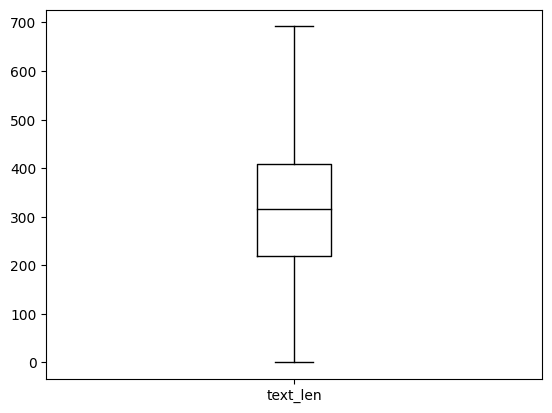

In [12]:
# 观察文本长度分布（排除异常值）
data_frame.boxplot('text_len', grid=False, showfliers=False, color='Black')
plt.suptitle("")
plt.xlabel("")
plt.show()
# 由图可知，取512足够覆盖正常样本
max_length = 512

In [13]:
# 去重choices，并保存原choices对应去重后的位置
unique_choices = np.unique(choices)
labels = np.array([np.argwhere(unique_choices==v)[0]  for v in choices])
unique_choices.shape, labels.shape

((5,), (99939, 1))

In [14]:
# 加入标签
data_frame.insert(0, 'label', value=labels)
data_frame[:10]

,label,接触ID,用户号码,来电时间,服务请求,转写文本,text_len
0,4,202301111449223447862S1,13924661819,2023-01-11 14:49:25,查询,哎我想问一下[SEP]我这个一三九的号码那个扣费方式是怎么样的[SEP]扣费方式的话它是每个...,621
1,0,2023011214193335844424S1,15817930939,2023-01-12 14:19:37,不满,喂我那个宽带不能用[SEP]宽带故障了是吗[SEP]哦现在不能用前前几天就不能用了[SEP]...,574
2,2,2023011117584374443240S1,18682452380,2023-01-11 17:58:48,咨询,哎我我办理这个那个我想问一下我这个号码有没有开通5g套餐呀[SEP]我看一下您这里有开通5g...,248
3,3,2023011111224925142885S1,17520581290,2023-01-11 11:22:53,无效来话,请不要挂机您拨叫的用户正在通话中请唔好挂机您拨叫凯用户正在通话中[SEP][SEP]嗯由于您...,80
4,3,2023011116155634245935S1,18929735508,2023-01-11 16:16:00,无效来话,喂我想咨询一下我的那个联通卡怎么回事啊[SEP]我都没用过[SEP]嗯您可以提供一下吗[SE...,459
5,4,2023011211202452445985S1,13268380631,2023-01-12 11:20:29,查询,嗯我想问一下我这个卡是啊升了5g上次是帮我升了5g然后现在是月租是54.5元上网费又是30一...,222
6,0,2023011221392818042574S1,18507625784,2023-01-12 21:41:50,不满,不要我有卡[SEP],10
7,0,2023011119235563644186S1,18575338828,2023-01-11 19:23:59,不满,我的号码为啥暂暂停服务了[SEP]稍等一下[SEP]我帮您看了一下的话您之前的话有反映过这个...,276
8,0,2023011214073176245834S1,13106672198,2023-01-12 14:07:36,不满,哎你查一下我这个话费还有余额吗[SEP]您这边还有8.95元[SEP]怎么打不了怎么没有信号...,245
9,4,2023011106133663642968S1,13215222179,2023-01-11 14:13:39,查询,哎先生[SEP]哦[SEP]嗯我想问一下现在如果这个号码要补号码的话那个身份证复印件有没有有...,103


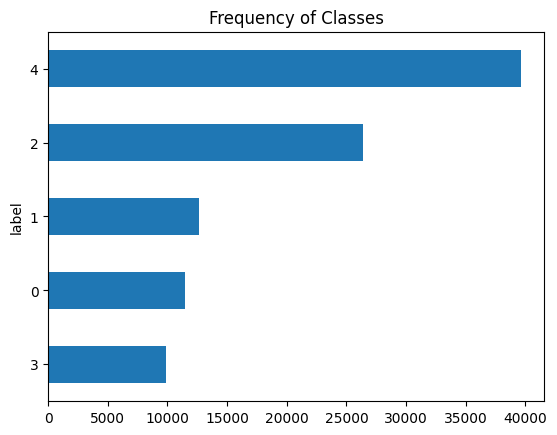

In [15]:
# 取出特征与labels
df = data_frame[['label', '转写文本', '服务请求']]
df[:10]
# 统计
df['label'].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In [16]:
# 手动处理样本非均衡情况
df4 = df[df['label'] == 4].sample(n=30000)
df2 = df[df['label'] == 2]
df1 = pd.DataFrame(np.repeat(df[df['label'] == 1].values, 2, axis=0), columns=df.columns)
df0 = pd.DataFrame(np.repeat(df[df['label'] == 0].values, 2, axis=0), columns=df.columns)
df3 = pd.DataFrame(np.repeat(df[df['label'] == 3].values, 2, axis=0), columns=df.columns)

df = pd.concat([df0, df1, df2, df3, df4], ignore_index=True)

In [17]:
# 先排序 label，以便后续充分打乱
df = df.sort_values(by='服务请求')

In [18]:
df

,label,转写文本,服务请求
0,0,喂我那个宽带不能用[SEP]宽带故障了是吗[SEP]哦现在不能用前前几天就不能用了[SEP]...,不满
15286,0,补丁1补丁和平的[SEP]你查一下我的网络怎么不正常呢现在没网络啊[SEP]帮您查询一下请稍...,不满
15285,0,嗯嗯那联通公司的好了[SEP]嗯对联通[SEP]嗯可以您说[SEP]怎么样啊这我呢就不知点解...,不满
15284,0,嗯嗯那联通公司的好了[SEP]嗯对联通[SEP]嗯可以您说[SEP]怎么样啊这我呢就不知点解...,不满
15283,0,[SEP]喂[SEP]啊有什么可以帮您[SEP]啊我是这个金平区那个护提路五十三号啊[SEP...,不满
...,...,...,...
104309,4,请讲喂哎我想问一下我现在那个流量包那个套餐还有还有2个吗还还是几个呀[SEP]呃您这个的话[...,查询
104308,4,哎帮我帮我把这个本机的号码私人手机号码[SEP]对本机号码是吧[SEP]那您现在欠费停机啊收...,查询
104307,4,哎就是说我这个号码哦这两个月它突然多了一个那个呃19块钱的那个什么节假日套餐那个流量啊我基本...,查询
104319,4,嗯你帮我查一下[SEP]我我这个1月[SEP]7月份[SEP]流量用了多少[SEP]啊稍等一...,查询


In [19]:
# 创建数据集
ds = DatasetDict({'train': Dataset.from_pandas(df)})
# ds['train'] = ds['train'].rename_column('转写文本','text')
ds = ds.remove_columns(['服务请求'])

ds['train'] = ds['train'].rename_columns({'转写文本':'text'})
ds = ds['train'].train_test_split(0.2, shuffle=True) # 按 8:2 分割数据集
ds, ds['train'][0], ds['test'][0]

(DatasetDict({
     train: Dataset({
         features: ['label', 'text', '__index_level_0__'],
         num_rows: 99454
     })
     test: Dataset({
         features: ['label', 'text', '__index_level_0__'],
         num_rows: 24864
     })
 }),
 {'label': 1,
  'text': '你帮我关一下流量畅享套餐[SEP]嗯稍等一下啊那个呃畅想钻石会员是吗[SEP]嗯[SEP]是啊对对对就那个25块一个月的那个[SEP]其实这个会员非常优惠建议您保留使用女士[SEP]嗯会员的话非常优惠建议您保留使用如果这边确实用不到也是可以取消需要验证一下您的6位数的服务密码还记得吗[SEP]密码密码不记得了[SEP]6位数[SEP]因为我帮您看到您这个已经取消了的呀到这个月底就就失效了没有了啊已经是取消过了[SEP]哦哦哦取消过了是吧但是他没给我发短信来[SEP]已经取消了啊没有了[SEP]哦好取消那就不用不用你取消了[SEP]嗯嗯我这边取消不到了他已经取消了的啊[SEP]嗯好[SEP]好好好谢谢啊麻烦你了[SEP]嗯好好嗯不客气嗯不客气嗯祝您生活愉快再见嗯',
  '__index_level_0__': 41476},
 {'label': 2,
  'text': '我帮你紧急开机[SEP]稍等[SEP]稍等[SEP]呃这边非常抱歉先生查询到您这个本月份的话已经是开过两次机了呀[SEP]已经到达上限了呀[SEP]您这边8号10号的话已经是开启过了呀[SEP]嗯[SEP]是[SEP]嗯也是非常抱歉的还有什么可以帮到您的呢[SEP]没有[SEP]嗯好的祝您生活愉快再见',
  '__index_level_0__': 68500})

In [20]:
%%time
model_path = './chinese-electra-base-discriminator'
tokenizer = AutoTokenizer.from_pretrained(model_path)
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=max_length)

tokenized_ds = ds.map(preprocess_function, batched=True)

Map: 100%|██████████| 24864/24864 [00:05<00:00, 4253.68 examples/s]

CPU times: user 2min 33s, sys: 709 ms, total: 2min 33s
Wall time: 29.3 s


In [21]:
# 模型
data_collator = DataCollatorWithPadding(tokenizer=tokenizer) # 允许不同长度tensor的存在
model_config = AutoConfig.from_pretrained(model_path)
model_config.num_labels = unique_choices.shape[0]
model = AutoModelForSequenceClassification.from_config(model_config)

In [22]:
tokenized_ds['train'][0]

{'label': 1,
 'text': '你帮我关一下流量畅享套餐[SEP]嗯稍等一下啊那个呃畅想钻石会员是吗[SEP]嗯[SEP]是啊对对对就那个25块一个月的那个[SEP]其实这个会员非常优惠建议您保留使用女士[SEP]嗯会员的话非常优惠建议您保留使用如果这边确实用不到也是可以取消需要验证一下您的6位数的服务密码还记得吗[SEP]密码密码不记得了[SEP]6位数[SEP]因为我帮您看到您这个已经取消了的呀到这个月底就就失效了没有了啊已经是取消过了[SEP]哦哦哦取消过了是吧但是他没给我发短信来[SEP]已经取消了啊没有了[SEP]哦好取消那就不用不用你取消了[SEP]嗯嗯我这边取消不到了他已经取消了的啊[SEP]嗯好[SEP]好好好谢谢啊麻烦你了[SEP]嗯好好嗯不客气嗯不客气嗯祝您生活愉快再见嗯',
 '__index_level_0__': 41476,
 'input_ids': [101,
  872,
  2376,
  2769,
  1068,
  671,
  678,
  3837,
  7030,
  4517,
  775,
  1947,
  7623,
  102,
  1638,
  4924,
  5023,
  671,
  678,
  1557,
  6929,
  702,
  1437,
  4517,
  2682,
  7183,
  4767,
  833,
  1447,
  3221,
  1408,
  102,
  1638,
  102,
  3221,
  1557,
  2190,
  2190,
  2190,
  2218,
  6929,
  702,
  8132,
  1779,
  671,
  702,
  3299,
  4638,
  6929,
  702,
  102,
  1071,
  2141,
  6821,
  702,
  833,
  1447,
  7478,
  2382,
  831,
  2669,
  2456,
  6379,
  2644,
  924,
  4522,
  886,
  4500,
  1957,
  1894,
  102,
  1638,
  833,
  1447,
  4638,
  6413,
  7478,
  2382

In [23]:
# 评估
accuracy = evaluate.load('./evaluate/metrics/accuracy/accuracy.py')
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [26]:
# 训练参数
training_args = TrainingArguments('./output',evaluation_strategy='epoch',save_strategy='epoch',
                                  load_best_model_at_end=True, num_train_epochs=9)
trainer = Trainer(model, args=training_args, train_dataset=tokenized_ds['train'], eval_dataset=tokenized_ds['test'], 
                  tokenizer=tokenizer, data_collator=data_collator, compute_metrics=compute_metrics)

In [ ]:
%%time
# 训练
trainer.train(resume_from_checkpoint=True)

Epoch,Training Loss,Validation Loss
